# Applying DeepLOB model to predict the results of horizon 20 on aggreggated Data from 5 stocks of Athex.

In [ ]:
# Importing the libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.models import Model
import tensorflow as tf
import keras

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data preparation

In [ ]:
# Functions to prepare the data for the model.
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:, k] - 1
    y = to_categorical(y, 3)
    return x, y


In [ ]:
# Load data
dec_data = np.loadtxt('train_case1.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
dec_test = np.loadtxt('test_case1.txt')

k = 1 # Which horizon to use for prediction
T = 100 # The input dimension (time steps)
n_hiddens = 64
checkpoint_filepath = './model_deeplob_k1/weights' # Where to save the model weights.

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(130731, 100, 40, 1) (130731, 3)
(32609, 100, 40, 1) (32609, 3)
(82162, 100, 40, 1) (82162, 3)


# Model Architecture


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(32, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(32, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(32, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)
    
    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)  # Change CuDNNLSTM to LSTM

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

2024-08-09 13:50:24.377438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 16)  48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 16)  1040        ['leaky_re_lu[0][0]']        

/Users/lamprosganias/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Model Training

In [6]:
# Set up the checkpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


# Train the model
deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=100, batch_size=32, verbose=1, callbacks=[model_checkpoint_callback,early_stopping])


Epoch 1/100
4086/4086 [==============================] - 364s 88ms/step - loss: 1.0274 - accuracy: 0.4466 - val_loss: 1.0055 - val_accuracy: 0.4734
Epoch 2/100
4086/4086 [==============================] - 357s 87ms/step - loss: 1.0037 - accuracy: 0.4655 - val_loss: 0.9935 - val_accuracy: 0.4740
Epoch 3/100
4086/4086 [==============================] - 353s 86ms/step - loss: 0.9926 - accuracy: 0.4771 - val_loss: 1.0015 - val_accuracy: 0.4640
Epoch 4/100
4086/4086 [==============================] - 350s 86ms/step - loss: 0.9842 - accuracy: 0.4866 - val_loss: 1.0076 - val_accuracy: 0.4598
Epoch 5/100
4086/4086 [==============================] - 346s 85ms/step - loss: 0.9773 - accuracy: 0.4959 - val_loss: 0.9743 - val_accuracy: 0.4956
Epoch 6/100
4086/4086 [==============================] - 356s 87ms/step - loss: 0.9696 - accuracy: 0.5051 - val_loss: 0.9630 - val_accuracy: 0.5243
Epoch 7/100
4086/4086 [==============================] - 349s 85ms/step - loss: 0.9612 - accuracy: 0.5158 - val_

# Model Testing

In [7]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

2568/2568 [==============================] - 68s 26ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.5011927655120372
              precision    recall  f1-score   support

           0     0.4711    0.4101    0.4385     26788
           1     0.5275    0.6622    0.5872     27606
           2     0.4925    0.4290    0.4586     27768

    accuracy                         0.5012     82162
   macro avg     0.4970    0.5004    0.4948     82162
weighted avg     0.4973    0.5012    0.4952     82162



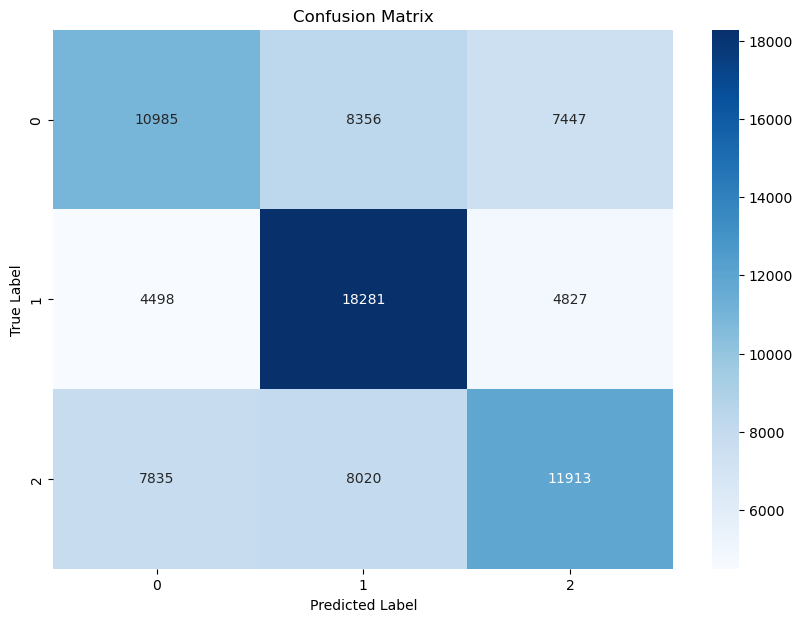

In [ ]:
# Convert one-hot encoded vectors to class labels
true_labels = np.argmax(testY_CNN, axis=1)
predicted_labels = np.argmax(pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()